Оценка степени ионизации из температуры
$X_p + X_p^2 n_B (\frac{2\pi}{m_e T})^{3/2}e^{\frac{\delta H}{T}} = 1$

$X_p = \frac{-1 \pm \sqrt{ 1 + 4(n_B (\frac{2\pi}{m_e T})^{3/2}e^{\frac{\delta H}{T}})}}{2 n_B (\frac{2\pi}{m_e T})^{3/2}e^{\frac{\delta H}{T}}}$

,где $\delta H = 13.6 эВ$, а $X_p = \frac{n_p}{n_B}$. Берем корень только с +, так как с - нефизичный.


Нагрев и охлаждение
Нагрев и охлаждение от ионизации и комптоновского рассеяния за счет аккреционного излучения уже учтены за счет членов связанных с излучением в уравнениях Эйлера.
Перераспределение температуры за счет теплопередачи в газе также учтено.
Не учтенным остается охлаждение газа за счет обратного комптоновского рассеяния с фотонами CMB.

Из статьи Кара:
$\Gamma_{rad} \approx \frac{n_H x k T \rho_r \sigma_T}{m_e c} \approx 10^{-31} x n_H z^{4} T_{4}$ $эрг$  $см^{-3}$ $с^{-1}$

In [1]:
def inv_compton_cool_rate(n_H,x,T,z,M_unit):
    return 1e-31 * x * n_H * z**4 * T/(1e4) * (1e-6 * 1e-7/M_unit) # в M_unit м**(-1) с**(-3)

In [2]:
def ioniz_estim(n_H, T):
    m_e = 0.5e6
    delta_H = 13.6
    T_new = T/11604 # температура в эВ
    if np.any((T_new<=0.02)):
        for i in range(T_new.shape[0]):
            if T_new[i]<=0.02:
                T_new[i]=0.02
    n_H_new = n_H*(1.2e-6)**3 # концентрация водорода в эВ^-3
    a = n_H_new*np.exp(delta_H/T_new)*(2*np.pi/(m_e*T_new))**(3/2)
    x = (-1 + np.sqrt(1+4*a))/(2*a)
    return x

In [3]:
def hubble_0(z):
    # t_eq = 47000  # время RD->MD
    # t_eq = 378000
    t_eq = 9.8e9
    # z_eq = 3119
    # z_eq = 1100
    z_eq = 0.85
    constant = 1/((1+z_eq)*t_eq**(2/3))
    t = (1/((1+z)*constant))**(3/2)  # грубая оценка в годах
    Hubble_const = 2/(3*t*31536000)  # в секундах**(-1)
    return  Hubble_const # грубая оценка на MD стадии
def hubble(z):
    hubble_const_0 = 2.2e-18  # в 1/c
    omega_m_0 = 0.25
    omega_lambda = 0.75
    a_0 = 1
    a = a_0/(1+z)
    hubble_const = hubble_const_0 * np.sqrt(omega_m_0*(a_0/a)**3 + omega_lambda)
    return hubble_const

In [4]:
import matplotlib.pyplot as plt
# Импорт функций для расчетов темной материи
from md import *
# Импорт функций для расчетов излучения
from light_func import *
%matplotlib inline
import numpy as np
plt.style.use(['seaborn-v0_8-notebook'])
plt.rcParams.update({"figure.facecolor": (0,0,0,0),
                     "figure.dpi": 90,
                     "animation.html": "jshtml",
                     "animation.embed_limit": 100})
plt.rcParams['font.size'] = 20

In [5]:
# Спектр фотонов
# Нужен L(\nu). Считаем спектр плоским, то есть dL/dE~E**(-1)
# E_light_range = [13.6, 0.5e6]  # в эВ
# E_light_number = 100  # кол-во значений
# def light_energies(E_light_range, E_light_number):
#     return [i for i in np.linspace(E_light_range[0],E_light_range[1],E_light_number)]
# def light_luminosity(E_light_range, E_light_number):
#     k = 10**40/np.sum([np.log(i) for i in light_energies(E_light_range, E_light_number)])
#     print(k)
#     return [k*np.log(i) for i in light_energies(E_light_range, E_light_number)]
# light_luminosity(E_light_range, E_light_number)

In [6]:
# Параметры задачи
z = 100 # Красное смещение на RD->MD
# z = 1100
# z = 100  # Красное смещение
M_pbh = 1e9 # масса черной дыры в солнечных массах
t_end_years = 1e9 # Конечное время симуляции в годах
draw_step = 10000 # Шаг для отрисовки

In [7]:
z_0 = z
z_new = z
kkk = 1.247e-7
a_0 = 1/(z+1)

In [8]:
# Множители для отладки
PP = 0  #множитель перед членом с давлением
GG = 1    #гравитационная постоянная (приравнять нулю, чтобы посмотреть только с давлением)
СС = 0   #множитель перед членом с комптоновским охлаждением в расчете энергии
RRRho = 1  #множитель увеличивающий начальную плотность в центральной граничной точке
TT = 1  # Множитель перед температурой в центре

In [9]:
# Различные физические константы
k = 1.38e-23*1e-40 # Постоянная Больцмана Дж/К
m_p = 1.67e-27 # Масса протона кг
c = 3e8 # Скорость света
pk_to_meter = 3.0857e16 # Переводной коэффициент пк->м
G = GG * 6.67e-11 # гравитационная постоянная Н*м^2/кг^2
M_sun = 2e30 # масса солнца в кг
gamma = 5/3 # коэффициент адиабаты
t_end_seconds = 3.154e7 * t_end_years


Rho_mean = 9.31e-27 * 0.04 * (1+z)**3 # Средняя плотность Вселенной
# Rho_mean = 3*hubble(z)**2/(8*np.pi*G)

In [10]:
Rho_mean

3.8368409239999997e-22

In [11]:
# Блок констант далее требуется для условия Куранта-Фридрихсона-Леви (КФЛ)
mu = 1 # Средний молекулярный вес, это значение для водорода, если будем что-то добавлять то будет что-то другое
a1 = 1/119  # первый коэффициент в формуле для температуры
a2 = 1/115  # второй коэффициент в формуле для температуры
T = 2.7 * (1+z) * (1 + a1**(-1)*(1+z)**(-1)/(1+a2**(3/2)*(1+z)**(3/2))) ** (-1)  # Температура Вселенной (это задание температуры не нужно тк она перезадается далее)
a = np.sqrt(k*T / (mu*m_p))   #скорость звука в м/c

# Радиус остановки DM
r_s = 6.7 * 10**22 * (M_pbh/10**9)**(1/3) * ((1+z)/18)**(-4/3) * 3.24 * 10**(-19)
r_virial = r_s/4

In [12]:
r_virial

544.2870440160802

In [13]:
# Диапазон сетки
r_min = r_virial#1 # внутренняя граница сетки в парсеках
r_max = 10*r_s#100 # внешняя граница сетки в парсеках

# # Логарифмическая сетка
# r_log_min = np.log(r_min)
# r_log_max = np.log(r_max)
# length_r = 30
# r_log = np.linspace(r_log_min, r_log_max, length_r)
# r_phys = np.exp(1) ** r_log
# log_step = r_log[1]-r_log[0]

# равномерная сетка
length_r = 30
r_phys = np.linspace(r_min, r_max, length_r)
lin_step = r_phys[1] - r_phys[0]
log_step = 1

In [14]:

# Задание первичного (пробного) условия КФЛ
# Далее условие будет пересчитываться
# Вид условия: С = ((a + |u_x|) * dt)/dx < 0.5
# Здесь a-эффективная скорость звука, u_x-скорость газа, dt и dx шаги по времени и пространству
# Константа в условии КФЛ
C = 0.1

# Для логарифмической сетки
dt = C * (r_phys[1]-r_phys[0]) * pk_to_meter / a

In [15]:
# Инициализация массивов для хранения различных переменных
length_r = r_phys.shape[0]
U = np.zeros((2, length_r)) # скорость газа U_0 = 0
Rho = np.zeros((2, length_r)) # плотность газа Rho
P = np.zeros((2, length_r)) # давление газа P
T = np.zeros(length_r) # температура газа T
Eps = np.zeros(length_r) # внутренняя энергия газа U
E = np.zeros((2, length_r)) # Полная энергия
n_H = np.zeros(length_r) # количественная плотность водорода
Phi = np.zeros(length_r)  # гравитационный потенциал
S_dual = np.zeros(length_r)
V_dual = np.zeros(length_r)
S = np.zeros(length_r)
V = np.zeros(length_r)
du_dr = np.zeros(length_r)
U_half = np.zeros(length_r)
Rho_U_half = np.zeros(length_r)

In [16]:
# Начальные условия
for j in range(r_phys.shape[0]):
    # Гравитационный потенциал
    Phi[j] = (-G*mdmt(r_phys[j]/r_s)/(r_phys[j] * pk_to_meter) * (Rho_mean * 4*np.pi/3 * (r_s*pk_to_meter)**3)
              -G*M_pbh*M_sun/(r_phys[j] * pk_to_meter)) # в м**2/с**2

    # Температура
    T[j] = 2.7 * (1+z) * (1 + a1**(-1)*(1+z)**(-1)/(1+a2**(3/2)*(1+z)**(3/2)))**(-1)  # в кельвинах

    # Плотность барионов
    # omega_b = 0.049
    # omega_m = 0.308
    # Rho[0, j] = omega_b * rrb(r_phys[j]/r_s)/omega_m    #пробная плотность в Rho_mean
    # Rho[0, j] = rrb(r_phys[j]/r_s)
    Rho[0,j] = 1

    # Так как переопределили Rho и оставили метры то нужно переопределить единицы массы
    M_unit = Rho_mean   # Коэффициент перевода единиц массы в кг

    # kkk = T/Rho[-1]
    # T = kkk * Rho

    # Концентрация водорода
    n_H[j] = (Rho[0, j])/(m_p/M_unit)

    # массовая плотность внутренней энергия
    Eps[j] = (3/2 * k * T[j])/m_p  # В Дж/M_unit

    # Скорости
    # U[0, j] = 0   # В м/c
    # U[0,j] = hubble(z) * r_phys[j]*pk_to_meter  # в м/с с учетом расширения Вселенной
    U[0,j] = np.sqrt(8/3*np.pi*G*Rho[0,j]*M_unit) * r_phys[j]*pk_to_meter
    # Плотность полной энергии
    E[0, j] = (Rho[0, j]) * (U[0, j]**2/2 + Eps[j]) # В (Дж/м**3)/M_unit   # Здесь индексы должны учитывать сдвиг между U и Rho

    # Уравнение состояния
    P[0, j] = (gamma - 1) * (Rho[0, j]) * Eps[j]   # Давление в M_unit/м*с**2

In [17]:
S.shape

(30,)

In [18]:
# Блок далее нужен для синхронизации размеров векторов, чтобы далее не возникало ошибок связанных с их несовпадением
# r_log_temp_2 = np.append(r_log[0] - log_step, r_log)
# r_log_temp_2 = np.append(r_log_temp_2, r_log[-1] + log_step)
# r_temp_2 = np.exp(1) ** r_log_temp_2
# # Phi_temp = (-G*mdmt(r_temp_2[0]/r_s)/(r_temp_2[0] * pk_to_meter) * (Rho_mean * 4*np.pi/3 * (r_s*pk_to_meter)**3)
# #               -G*M_pbh*M_sun/(r_temp_2[0] * pk_to_meter))
# # Phi_temp_2 = (-G*mdmt(r_temp_2[-1]/r_s)/(r_temp_2[-1] * pk_to_meter) * (Rho_mean * 4*np.pi/3 * (r_s*pk_to_meter)**3)
# #               -G*M_pbh*M_sun/(r_temp_2[-1] * pk_to_meter))
# r_log_temp = np.append(r_log, r_log[-1] + log_step)
# r_temp = np.exp(1) ** r_log_temp
# r_log_temp_dop = np.append(r_log_temp, r_log_temp[-1]+log_step)
# r_temp_dop = np.exp(1) ** r_log_temp_dop
# r_log_temp_2 = r_log_temp - 0.5*log_step
# r_temp_3 = np.exp(1) ** r_log_temp_2

In [19]:
# # Задание обьемов и площадей для log сетки
# r_phys_temp = np.exp(1)**(np.append(r_log,r_log[-1]+log_step))  # этот вектор нужен для задания обьемов ячеек по U и площадей по rho, он на один длиннее так как в расчете этих величин нужно вычитать соседние элементы
# r_phys_temp_2 = np.append(r_phys_temp,np.exp(1)**(r_log[-1]+2*log_step)) # этот вектор нужен для задания обьемов ячеек по rho поэтому на один длиннее чем предыдущий
# r_phys_rho = (r_phys_temp[1:]+r_phys_temp[:-1])/2
# r_phys_rho_for_V = (r_phys_temp_2[1:]+r_phys_temp_2[:-1])/2
# S = 4 * np.pi * r_phys_rho**2 * pk_to_meter**2
# V = 4/3 * np.pi * (r_phys_rho_for_V[1:]**3 - r_phys_rho_for_V[:-1]**3) * pk_to_meter**3
#
# S_dual = 4 * np.pi * r_phys**2 * pk_to_meter**2
# V_dual = 4/3 * np.pi * (r_phys_temp[1:]**3 - r_phys_temp[:-1]**3) * pk_to_meter**3  # r_phys_temp это вектор на один элемент длиннее чем r_phys

# для равномерной сетки
r_phys_temp = np.append(r_phys, r_phys[-1]+lin_step)
r_phys_temp_2 = np.append(r_phys_temp,r_phys_temp[-1]+lin_step)
r_phys_rho = (r_phys_temp[1:]+r_phys_temp[:-1])/2
r_phys_rho_for_V = (r_phys_temp_2[1:]+r_phys_temp_2[:-1])/2

S = 4 * np.pi * (r_phys_rho)**2 * pk_to_meter**2
V = 4/3 * np.pi * (r_phys_rho_for_V[1:]**3 - r_phys_rho_for_V[:-1]**3) * pk_to_meter**3

S_dual = 4 * np.pi * r_phys**2 * pk_to_meter**2
V_dual = 4/3 * np.pi * (r_phys_temp[1:]**3 - r_phys_temp[:-1]**3) * pk_to_meter**3  # r_phys_temp это вектор на один элемент длиннее чем r_phys

# # Для геометрии трубы с постоянным сечением в равномерной сетке
# r_phys_temp = np.append(r_phys, r_phys[-1]+lin_step)
# r_phys_temp_2 = np.append(r_phys_temp,r_phys_temp[-1]+lin_step)
# r_phys_rho = (r_phys_temp[1:]+r_phys_temp[:-1])/2
# r_phys_rho_for_V = (r_phys_temp_2[1:]+r_phys_temp_2[:-1])/2
#
# S = 1.065e36*np.ones(length_r)
# V = S*(r_phys_rho_for_V[1:]-r_phys_rho_for_V[:-1])*pk_to_meter
#
# S_dual = 1.065e36*np.ones(length_r)
# V_dual = S_dual*(r_phys_temp[1:]-r_phys_temp[:-1])*pk_to_meter  # r_phys_temp это вектор на один элемент длиннее чем r_phys

In [20]:
# Задание температуры как функции от плотности барионов

# Коэффициент при плотности в выражении для температуры
# kkk = T(на границе)/Rho(на границе)
# kkk = T/Rho[-1]
# T = kkk * Rho

In [21]:
# Изменение размеров векторов и применение граничного условия к потенциалам
# Phi = np.append(Phi_temp, Phi)
# Phi = np.append(Phi, Phi_temp_2)
P[0, -1] = P[0, -2]
# U[0, -1] = U[0, -2]

# Искуственное увеличение плотности и температуры в центре (работает если был изменен соответствующий отладочный параметр)
Rho[0,0] = Rho[0,0]*RRRho
T[0] = T[0]*TT

In [22]:
# Инициализация различных переменных для расчета
i = 0 # Счетчик шагов по времени
sim_time = 0 # Общее время симуляции
dt_minimizer = 0.0009 # Множитель который будет использован при пересчете шагов по времени
indicator_2 = False # Индикатор нужный для пересчета шага по времени
Rho_dump_left = np.zeros(2) # Переменная для хранения плотности которая уходит к ЧД за пределы сетки
LL = np.zeros(length_r)  # Переменная для хранения разницы членов гравитации и давления

# Массивы для отрисовки
U_draw = np.zeros((2,Rho.shape[1]))
Rho_draw = np.zeros((2,Rho.shape[1]))
E_draw = np.zeros((2,Rho.shape[1]))
T_draw = np.zeros((2,Rho.shape[1]))
Eps_draw = np.zeros((2,Rho.shape[1]))
U_draw[1,:] = U[0, :]
Rho_draw[1,:] = Rho[0, :]
E_draw[1,:] = E[0, :]
T_draw[1,:] = T
z_draw = z
Eps_draw[1,:] = Eps
draw_time = 0

In [23]:
# Выбор начального распределения степени ионизации и процедуры расчета излучения
x = np.exp(-5*r_phys/r_s) # Начальное распределение степени ионизации
x_draw = x  # Массив для отрисовки степени ионизации
E_photon = 1000 # Энергия фотонов в эВ
light_procedure_selector = -1   # 0 - для простой оценки, 1 - для минимального расчета потерь излучения из уравнения переноса, -1 - для выключения света

In [24]:
# Расчет решения уравнений Эйлера с излучением
# heat_conductivity_interpol = 10/M_unit
heat_conductivity_interpol = 0
dT_dx = np.zeros(length_r)
ddT_dx = np.zeros(length_r)
dPhi_dx = np.zeros(length_r)
t_eq = 80000
sign_norm_A_intern = -1
sign_norm_A_outward = +1
while (sim_time < t_end_seconds):
    if (i == 0):
        i = 1

    # Лагранжев шаг

    # Вычисление скорости на полшага вперед по времени
    dP_dx = (P[0,1:] - P[0,:-1]) / log_step
    # dPhi_dx = (Phi[1:] - Phi[:-1]) / log_step
    # dPhi_dx = (-G*mdmt(r_phys/r_s)/(r_phys * pk_to_meter)**2 * (Rho_mean * 4*np.pi/3 * (r_s*pk_to_meter)**3)
    #           -G*M_pbh*M_sun/(r_phys * pk_to_meter)**2)
    dPhi_dx = 4/3*np.pi*G*Rho[0,:]*M_unit*r_phys_rho*pk_to_meter
    # dPhi_dx = hubble(z_new)**2 * ((r_phys*pk_to_meter**2))/2
    # dPhi_dx = 8*np.pi*Rho[0,:]*r_phys*pk_to_meter/6
    r_s = 6.7 * 10**22 * (M_pbh/10**9)**(1/3) * ((1+z_new)/18)**(-4/3) * 3.24 * 10**(-19)
    dT_dx[:-1] = (T[1:]-T[:-1])/ log_step
    dT_dx[-1] = dT_dx[-2]
    ddT_dx[:-1] = (dT_dx[1:] - dT_dx[:-1])/ log_step
    ddT_dx[-1] = ddT_dx[-2]

    if light_procedure_selector == 1:
        H, Pressure_euler_coupling, Energy_euler_coupling = eddington_light(n_H, x, E_photon, M_pbh, r_phys, M_unit)
        LL[:-1] = (- PP * (0.5*dt * dP_dx/(r_phys[:-1] * pk_to_meter)) / (Rho[0,:-1])
                                - (0.5*dt * np.where(dPhi_dx[:-1]>0,1,0) * dPhi_dx[:-1]/(r_phys[:-1] * pk_to_meter))
                                - 0.5*dt*Pressure_euler_coupling/(Rho[0,:-1]))
    elif light_procedure_selector == 0:
        H, Pressure_euler_coupling, Energy_euler_coupling = easy_eddington_light(x, r_phys, M_pbh)
        LL[:-1] = (- PP * (0.5*dt * dP_dx/(r_phys[:-1] * pk_to_meter)) / (Rho[0,:-1])
                                - (0.5*dt * np.where(dPhi_dx[:-1]>0,1,0) * dPhi_dx[:-1]/(r_phys[:-1] * pk_to_meter))
                                - 0.5*dt*Pressure_euler_coupling/Rho[0,:-1])
    elif light_procedure_selector == -1:
        H, Pressure_euler_coupling, Energy_euler_coupling = no_light()
        LL[:-1] = (- PP * (0.5*dt * dP_dx/(r_phys[:-1] * pk_to_meter)) / (Rho[0,:-1])
                                - (0.5*dt * np.where(dPhi_dx[:-1]>0,1,0) * dPhi_dx[:-1])
                                - 0.5*dt*Pressure_euler_coupling/Rho[0,:-1])

    # тестовый
    H, Pressure_euler_coupling, Energy_euler_coupling = no_light()
    # LL[:-1] = (- PP * (0.5*dt * dP_dx/(r_phys[:-1] * pk_to_meter))/Rho[0,:-1]
    #                             - (0.5*dt * dPhi_dx[:-1])
    #                             - 0.5*dt*Pressure_euler_coupling/Rho[0,:-1])
    LL[:-1] = (- PP * (0.5*dt * dP_dx/(r_phys[:-1] * pk_to_meter))
                                - (0.5*dt * dPhi_dx[:-1])
                                - 0.5*dt*Pressure_euler_coupling)

    # Rho_U_half[:-1] = Rho[0,:-1]*U[0,:-1] + LL[:-1]   # в M_unit/(м**2 * с)
    # Rho_U_half[-1] = Rho_U_half[-2]
    # U_half[:-1] = Rho_U_half[:-1]/(Rho[0,:-1])  # в м/c
    U_half[:-1] = U[0,:-1] + LL[:-1]

    U_half[-1] = ((U_half[-3] - U_half[-2])/(r_phys[-3]-r_phys[-2]))*(r_phys[-1]-r_phys[-2]) + U_half[-2]
    # Rho_U_half[-1] = ((Rho_U_half[-3] - Rho_U_half[-2])/(r_phys[-3]-r_phys[-2]))*(r_phys[-1]-r_phys[-2]) + Rho_U_half[-2]
    # Вычисление производной скорости по времени
    du_dx = (U_half[1:] - U_half[:-1]) / log_step
    du_dr[:-1] = du_dx / (r_phys[:-1] * pk_to_meter)
    du_dr[-1] = du_dr[-2]

    # Промежуточная полная энергия
    if light_procedure_selector == 1:
        Energy_euler_coupling = np.append(Energy_euler_coupling, 0)

    E_inter = (E[0,:] - PP * P[0,:]*du_dr*0.5*dt
               - Rho[0,:] * U_half[:] * np.where(dPhi_dx>0,1,0) * dPhi_dx * 0.5*dt
                        -0.5*dt*Energy_euler_coupling/(log_step*r_phys*pk_to_meter)
                        + 0.5*dt*heat_conductivity_interpol*ddT_dx/(r_phys*pk_to_meter)**2
                        - СС*0.5*dt*inv_compton_cool_rate(n_H,x,T,z_new,M_unit))

    # Шаг адвекции
    # В зависимости от направления скорости переносим параметры (плотность, энергию) из одной ячейки в другую

    # Вычисление плотности

    # Rho[1,:-1] = Rho[0,:-1] - np.abs((dt * Rho[0,:-1] * U_half[:-1] * S[:-1]) / V[:-1])
    # # Следующую строчку нужно использовать чтобы вещество вылетало к центру. Ту что далее тогда нужно закомментировать
    # # Rho[1,0] = Rho[0,0] - np.abs((dt * Rho[0,0] * U_half[0] * S[0]) / V[0])
    # # Следующую строчку нужно использовать если нужно накапливать плотность крайней точке. Ту что до этого тогда нужно закомментировать
    # # Rho[1,0] = Rho[0,0] - np.abs((dt * Rho[0,0] * U_half[0] * S[0]) / V[0])*(U_half[0]>0)
    # # Rho_dump_left[1] = Rho_dump_left[0] + np.abs((dt * Rho[0,0] * U_half[0] * S[0]) / V[0]) * (U_half[0]<0)

    # Rho[1,0] = Rho[1,0] + dt * Rho
    # Rho[1,0] = Rho[1,1]


    # Rho[1,1:-1] = (Rho[0,1:-1] + dt*(-sign_norm_A_intern*Rho_U_half[1:-1]*S_dual[1:-1]/V_dual[1:-1] - sign_norm_A_outward*Rho_U_half[2:]*S_dual[2:]/V_dual[1:-1]))

    # Rho[1,1:-1] = (Rho[0,1:-1] + dt*(-sign_norm_A_intern*Rho[0,:-2]*U_half[1:-1]*S_dual[1:-1]/V_dual[1:-1]
    #                                  - sign_norm_A_outward*Rho[0,1:-1]*U_half[2:]*S_dual[2:]/V_dual[1:-1]))
    # Rho[1,1:-1] = (Rho[0,1:-1] + dt*(-sign_norm_A_intern*Rho[0,:-2]*U_half[1:-1]*S_dual[1:-1]/V_dual[1:-1]
    #                                  - sign_norm_A_outward*Rho[0,1:-1]*U_half[2:]*S_dual[2:]/V_dual[1:-1]))



    # U[1,1:-1] = (Rho[0,1:-1]*U[0,1:-1] - dt*sign_norm_A_intern*((Rho_U_half[:-2]+Rho_U_half[1:-1])/2)*((U_half[1:-1]+U_half[:-2])/2)*S[:-2]/V[:-2] - dt*sign_norm_A_outward*((Rho_U_half[1:-1]+Rho_U_half[2:])/2)*((U_half[2:]+U_half[1:-1])/2)*S[1:-1]/V[:-2])/Rho[1,1:-1]
    # U[1,1:-1] = (Rho[0,1:-1]*U[0,1:-1] - dt*sign_norm_A_intern*(Rho_U_half[1:-1])*((U_half[1:-1]+U_half[:-2])/2)*S[:-2]/V[:-2] - dt*sign_norm_A_outward*(Rho_U_half[2:])*((U_half[2:]+U_half[1:-1])/2)*S[1:-1]/V[:-2])/Rho[1,1:-1]
    # U[1,1:-1] = (U[0,1:-1]*Rho[0,1:-1] - dt*sign_norm_A_intern*Rho[0,:-2]*U[0,:-2]*U_half[:-2]*S[:-2]/V[1:-1]
    #                                    - dt*sign_norm_A_outward*Rho[0,1:-1]*U[0,1:-1]*U_half[1:-1]*S[1:-1]/V[1:-1])/Rho[1,1:-1]
    # U[1,1:-1] = (Rho[0,1:-1]*U[0,1:-1] - dt*sign_norm_A_intern*((Rho[1,1:-1]+Rho[0,1:-1])/2)*(((U_half[1:-1]+U_half[:-2])/2)**2)*S[1:-1]/V[1:-1] - dt*sign_norm_A_outward*((Rho[1,1:-1]+Rho[0,1:-1])/2)*(((U_half[2:]+U_half[1:-1])/2)**2)*S[2:]/V[1:-1])/Rho[1,1:-1]
    # U[1,:-1] = Rho[0,:-1]*U[0,:-1]/Rho[1,:-1] - dt*sign_norm_A_intern*(Rho[])

    # E[1,:-1] = (E[0,:-1] + dt*(-sign_norm_A_intern*E_inter[:-1]*U_half[:-1]*S_dual[:-1]/V_dual[:-1] - sign_norm_A_outward*E_inter[:-1]*U_half[1:]*S[1:]/V[:-1]))

    # - np.where(U_half[:-1]<0,1,0)*np.abs((dt * Rho[0,:-2] *  U_half[1:-1] * S_dual[1:-1]) / V_dual[1:-1])
    Rho[1,1:-1] = Rho[0,1:-1] - np.abs(dt * Rho[0,1:-1] * U_half[2:] * S_dual[2:] / V_dual[1:-1])

    # Rho[1,:-1] = Rho[1,:-1] + np.abs((dt * Rho[0,1:] * U_half[1:] * S[1:]) / V[:-1]) * np.where(U_half[1:]<0, 1, 0)
    Rho[1,1:-1] = Rho[1,1:-1] + np.abs(dt * Rho[0,:-2] * U_half[1:-1] * S_dual[1:-1] / V_dual[:-2])

    Rho[1,-1] = Rho[1,-2]
    Rho[1,0] = Rho[1,1]
    # Rho[1,0] = Rho[1,0] =
    # Вычисление скорости
    # - np.where(U_half[:-1]<0,1,0)*np.sign(U_half[:-1]) * (dt * Rho[0,:-1] * U_half[:-1] ** 2 * S[:-1]) / V[:-1]
    U[1,1:-1] = (U[0,1:-1]*Rho[0,1:-1] - (dt * Rho[0,1:-1]*((U_half[2:]+U_half[1:-1])/2) * U[0,1:-1] * S[1:-1]) / V[1:-1])/Rho[1,1:-1]
    # # # # U[1,:-1] = U[0,:-1] - np.sign(U_half[:-1]) * (dt * U_half[:-1] ** 2 * S_dual[:-1]) / V_dual[:-1]
    # # # # U[1,:] = np.sign(U_half) * np.abs(np.abs(U[0,:]) - dt * U_half ** 2 * S_dual) / (V_dual)
    # U[1,:-1] =  U[1,:-1] + np.sign(U_half[1:])*( dt * U_half[1:]**2 * S_dual[1:]) / (V_dual[:-1]) * np.where(U_half[1:]<0, 1, 0)*Rho[0,:-1]/Rho[1,:-1]
    U[1,1:-1] = U[1,1:-1] + (dt * Rho[0,:-2]*((U_half[:-2]+U_half[1:-1])/2)*U[0,:-2] * S[:-2]) / (V[1:-1])/Rho[1,1:-1]

    U[1,-1] = ((U[1,-3] - U[1,-2])/(r_phys[-3]-r_phys[-2]))*(r_phys[-1]-r_phys[-2]) + U[1,-2]
    U[1,0] = ((U[1,4] - U[1,5])/(r_phys[4]-r_phys[5]))*(r_phys[0]-r_phys[5]) + U[1,5]
    # U[1,-1] = hubble(z_new)*r_phys[-1]*pk_to_meter
    # U[1,0] = hubble(z_new)*r_phys[0]*pk_to_meter
    # z_new = 1/(a_0 + kkk*(sim_time*3.169e-8)**(2/3))-1
    # U[1,:] = hubble(z_new) * r_phys * pk_to_meter


    # Rho[1,:] = np.where(Rho[1,:]<0,0,1)*Rho[1,:]
    #
    # Rho[1,:] = np.where(Rho[1,:]==0,Rho_mean,Rho[1,:])

    # Rho[1,0] = ((sim_time*3.169e-8+t_eq)/t_eq)**-2
    # Rho[1,-1] = ((sim_time*3.169e-8+t_eq)/t_eq)**-2

    # Вычисление полной энергии
    E[1,:-1] = (E[0,:-1] - np.where(U_half[:-1]<0,1,0) * dt * E_inter[:-1] * U_half[1:] * S[:-1]/V[:-1]
                         - np.where(U_half[:-1]>0,1,0) * dt * E_inter[:-1] * U_half[1:] * S[1:]/V[:-1])
    # # # E[1,:-1] = E[0,:-1] - dt * E_inter[:-1] * U_half[:-1] * S[:-1]/V[:-1]
    # # # E[1,:] = np.abs(E[0,:]) - np.abs((dt * E_inter * U_half * S) / V)
    E[1,:-1] = E[1,:-1] + ((dt * E_inter[1:] * U_half[1:] * S[1:])/V[:-1]) * np.where(U_half[1:]<0, 1, 0)
    E[1,1:] = E[1,1:] + ((dt * E_inter[:-1] * U_half[:-1] * S[1:])/V[1:]) * np.where(U_half[:-1]>0, 1, 0)
    # E[1,0] = E[1,1]
    E[1,-1] = E[1,-2]

    # E[1,:] = np.where(E[1,:]<0,0,E[1,:])

    # print('Rho',Rho[1,:])
    # print('E',E[1,:])
    # Расчет внутренней энергии
    # m = Rho[1,:] * V
    Eps[:-1] = (E[1,:-1]/Rho[1,:-1] - (U[1,1:]**2)/2) #- m*Phi[:-2]
    Eps[-1] = Eps[-2]
    # Eps = np.where(Eps<0,0,Eps)
    # n_H = Rho[1,:]/(m_p/M_unit)
    T = m_p*Eps/(3/2*k)
    # T[-1] = 2.7 * (1+z_new) * (1 + a1**(-1)*(1+z_new)**(-1)/(1+a2**(3/2)*(1+z_new)**(3/2)))**(-1)
    # T[-2] = T[-1]

    # Условный оператор для остановки расчета при получении некорректных значений
    if np.any(np.isnan(Rho[1,:])):
        print(U_half)
        break

    # Обновление шага по времени, чтобы он отвечал условию КФЛ
    # Если пересчитываем шаг по времени нужно перезапустить этот шаг сначала (делаем Indicator = False)
    # Если условие КФЛ продолжает выполняться то делаем Indicator = True
    # Если индикатор со значением True выживет до конца шага цикла, то мы должны перейти на следующий временной слой
    if i==1:
        dt_new = (C * ((r_phys[1:]-r_phys[:-1]) * pk_to_meter) / (a + (np.abs(U[1,1:])))).min()
    else:
        dt_new = 0.1*((C * ((r_phys[1:]-r_phys[:-1]) * pk_to_meter) / (a + (np.abs(U[1,1:])))).min())

    if (dt_new < dt):
        # print(dt, '$$', i)
        dt = dt_new
        indicator = False
        indicator_2 = True
        print(dt, '&&', i)
        print('U_max',U.max())
        continue

    elif (dt_new >= dt):
        indicator = True
        # Следующий условный оператор нужен чтобы увеличить шаг по времени после пересчета первого шага
        # Это нужно так как при первом пересчете шаг по времени получается излишне маленьким
        if indicator_2 == True and i == 1:
            dt = dt_new * dt_minimizer
            indicator_2 = False
            continue


    # Обновление давления
    P[1,:] =  (gamma - 1) * (Rho[1,:]) * 3/2 * k * T / m_p

    # Обновление степени ионизации
    # x = ioniz_frac(H, n_H, x, E_photon, r_phys, T, M_pbh, M_unit, dt)
    x = ioniz_estim(n_H,T)
    # Пересчет гравитационного потенциала (аккреция)
    # M_pbh_accreted = (V[1] * Rho_mean * np.abs((dt * Rho[0,1] * U_half[1] * S[1]) / V[1]) * (U_half[1]<0))/M_sun
    # M_pbh += M_pbh_accreted
    # Phi[:-1] -= -G * M_pbh_accreted * M_sun/(r_temp * pk_to_meter)

    # Если индикатор равен True, то идем на следующий временной слой, если равен False, то повторяем текущий
    # Записываем в массив все значения шага по времени которые не вызвали пересчет слоя
    if (indicator == True):
        # Увеличиваем время симуляции
        sim_time += dt

        # Сохраняем значения массивов через draw_step для последующей отрисовки
        if (i%draw_step == 0):
            U_draw = np.vstack([U_draw, U[1,:]])
            Rho_draw = np.vstack([Rho_draw, Rho[1,:]])
            E_draw = np.vstack([E_draw, E[1,:]])
            x_draw = np.vstack([x_draw, x])
            T_draw = np.vstack([T_draw, T])
            Eps_draw = np.vstack([Eps_draw, Eps])
            draw_time = np.append(draw_time, sim_time)

            z_new = 1/(a_0 + kkk*(sim_time*3.169e-8)**(2/3))-1
            z_draw = np.append(z_draw,z_new)

            print('Номер шага ', i)
            print('Прошло ', sim_time * 3.169e-8, 'лет')
            print('Текущий z ', z_new)

        # Присвоение новых значений массивам
        U[0,:] = U[1,:]
        Rho[0,:] = Rho[1,:]
        E[0,:] = E[1,:]
        P[0,:] = P[1,:]
        Rho_dump_left[0] = Rho_dump_left[1]

        U[1,:] = 0
        Rho[1, :] = 0
        E[1, :] = 0
        P[1, :] = 0
        i = i + 1

print('Общее время симуляции равно', sim_time * 3.169e-8, 'лет')

1936715136262.5305 && 1
U_max 311064.7538203949
Номер шага  10000
Прошло  2075941.3521405417 лет
Текущий z  82.82035966897102
Номер шага  20000
Прошло  4151882.7042832407 лет
Текущий z  75.20626790345018
Номер шага  30000
Прошло  6227824.056421907 лет
Текущий z  69.8111274956063
Номер шага  40000
Прошло  8303765.408559838 лет
Текущий z  65.6024202619377
Номер шага  50000
Прошло  10379706.760697769 лет
Текущий z  62.15261442890871


KeyboardInterrupt: 

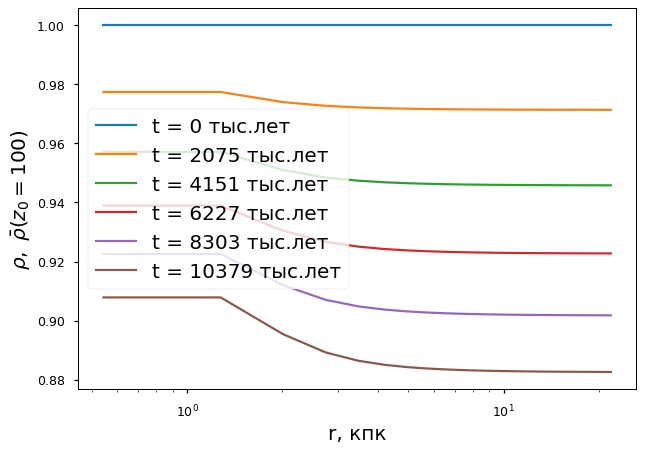

In [25]:
# Отрисовка плотности
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 0
draw_time_step = 1

fig, ax = plt.subplots()

for t in range(draw_time_zero, Rho_draw.shape[0]-1, draw_time_step):
    ax.plot(r_phys[:]*1e-3, Rho_draw[t+1, :],  label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.legend(fontsize = Font)
ax.set_xlabel(r"r, кпк",fontsize = Font)
ax.set_ylabel(r"$\rho,$ $\bar\rho(z_0=$"+f"{z_0})",fontsize = Font)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(-1, 1.5)
# ax.set_xlim(0,9)

#Добавляем вертикальные линии в точках r_virial и r_s
# plt.vlines(x=[r_virial*1e-3, r_s*1e-3], ymin=0.1, ymax=Rho_draw.max(), colors=['red', 'blue'], linestyles='dashed')

# plt.text(x=r_virial*1e-3+0.0001, y=0.1, s=r"$r_{virial}$", color='red', rotation=90)
# plt.text(x=r_s*1e-3+0.001, y=0.1, s=r"$r_{stop}$", color='blue', rotation=90)

plt.show()
# plt.savefig('Rho_1.png')

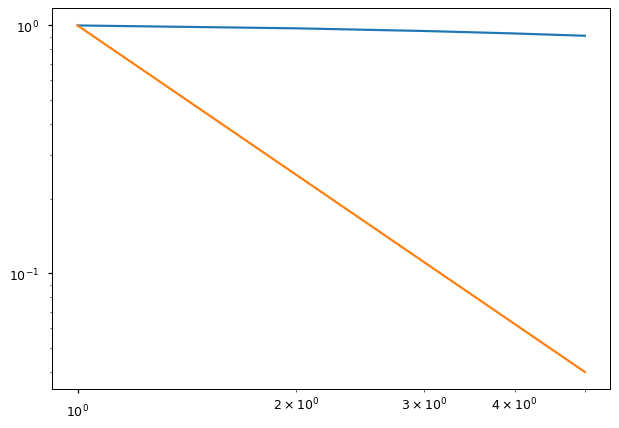

In [26]:
# Отрисовка плотности
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 1
draw_time_step = 1

fig, ax = plt.subplots()
t_eq = 80000
ax.plot((draw_time[1:])/draw_time[1], Rho_draw[2:, -1]/Rho_draw[2, -1],  label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot((draw_time[1:])/(draw_time[1]),((draw_time[1:])/draw_time[1])**-2)
# ax.set_ylim(0.001,1.1)

In [27]:
((draw_time[1:]*3.169e-8)/(draw_time[1])*3.169e-8)**-2

array([9.91541836e+29, 2.47885459e+29, 1.10171315e+29, 6.19713648e+28,
       3.96616735e+28])

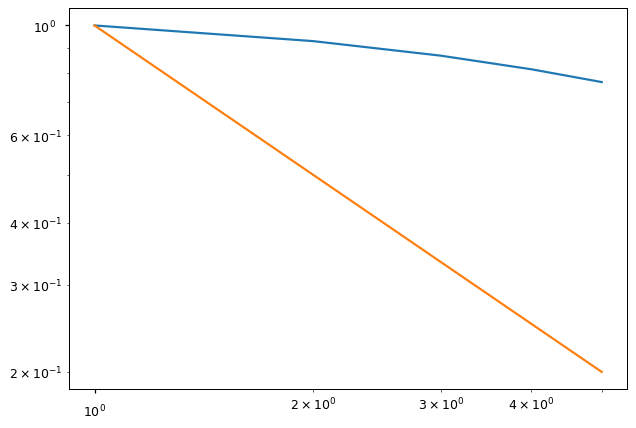

In [28]:
# Отрисовка скорости
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 1
draw_time_step = 1

fig, ax = plt.subplots()
t_eq = 500000
ax.plot((draw_time[1:])/draw_time[1], U_draw[2:, -1]/U_draw[2, -1],  label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot((draw_time[1:])/(draw_time[1]),((draw_time[1:])/draw_time[1])**-1)
# ax.set_ylim(0.001,1.1)

In [ ]:
fig, ax = plt.subplots()
start_t = 1
for i in range(20,T_draw.shape[1]-1):
    ax.plot(z_draw[start_t:],T_draw[start_t:-1,i],label=i)
ax.legend(fontsize = Font)
ax.invert_xaxis()
# ax.set_ylim(0,0.00000000001)

In [ ]:
# Отрисовка внутренней Энергии
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 1
draw_time_step = 1

fig, ax = plt.subplots()

for t in range(draw_time_zero, Eps_draw.shape[0]-1, draw_time_step):
    ax.plot(r_phys[:]*1e-3, Eps_draw[t, :], label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.legend(fontsize = Font)
ax.set_xlabel(r"r, кпк",fontsize = Font)
ax.set_ylabel(r"Eps",fontsize = Font)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(-1, 0.5)
# ax.set_xlim(0,9)

#Добавляем вертикальные линии в точках r_virial и r_s
plt.vlines(x=[r_virial*1e-3, r_s*1e-3], ymin=0.1, ymax=E_draw.max(), colors=['red', 'blue'], linestyles='dashed')

plt.text(x=r_virial*1e-3+0.0001, y=0.1, s=r"$r_{virial}$", color='red', rotation=90)
plt.text(x=r_s*1e-3+0.001, y=0.1, s=r"$r_{stop}$", color='blue', rotation=90)

plt.show()
# plt.savefig('E_1.eps')

In [ ]:
# Отрисовка полной Энергии
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 1
draw_time_step = 1

fig, ax = plt.subplots()

for t in range(draw_time_zero, E_draw.shape[0]-1, draw_time_step):
    ax.plot(r_phys[:]*1e-3, E_draw[t, :], label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.legend(fontsize = Font)
ax.set_xlabel(r"r, кпк",fontsize = Font)
ax.set_ylabel(r"E",fontsize = Font)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(-1, 1e10)
# ax.set_xlim(0,0.01)

#Добавляем вертикальные линии в точках r_virial и r_s
plt.vlines(x=[r_virial*1e-3, r_s*1e-3], ymin=0.1, ymax=E_draw.max(), colors=['red', 'blue'], linestyles='dashed')

plt.text(x=r_virial*1e-3+0.0001, y=0.1, s=r"$r_{virial}$", color='red', rotation=90)
plt.text(x=r_s*1e-3+0.001, y=0.1, s=r"$r_{stop}$", color='blue', rotation=90)

plt.show()
# plt.savefig('E_1.eps')

In [ ]:
# Отрисовка степени ионизации
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 0
draw_time_step = 1

fig, ax = plt.subplots()

for t in range(draw_time_zero, x_draw.shape[0], draw_time_step):
    ax.plot(r_phys[:]*1e-3, x_draw[t, :], label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.legend(fontsize = Font)
ax.set_xlabel(r"r, кпк",fontsize = Font)
ax.set_ylabel(r"x",fontsize = Font)


ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(-0.1, 0.5)
# ax.set_xlim(0,9)

#Добавляем вертикальные линии в точках r_virial и r_s
plt.vlines(x=[r_virial*1e-3, r_s*1e-3], ymin=0.1, ymax=x_draw.max(), colors=['red', 'blue'], linestyles='dashed')

plt.text(x=r_virial*1e-3+0.0001, y=0.1, s=r"$r_{virial}$", color='red', rotation=90)
plt.text(x=r_s*1e-3+0.001, y=0.1, s=r"$r_{stop}$", color='blue', rotation=90)

plt.show()
# plt.savefig('Rho_1.eps')

In [ ]:
# Отрисовка скорости
import matplotlib.pyplot as plt

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 1
draw_time_step = 1

# создаем фигуру и оси
fig, ax = plt.subplots()

# перебираем значения draw_time от 0 до length_t-1 с шагом draw_time_step
for t in range(draw_time_zero, U_draw.shape[0]-1, draw_time_step):
    # рисуем график значений Rho[t, :] и r[:] с подписью t
    ax.plot(r_phys[:], U_draw[t, :], label=f"t = {int(draw_time[t] * 3.169e-8)}")

# for t in range(draw_time_zero, Rho_draw.shape[0]-1, draw_time_step):
#     ax.plot(r_phys[:]*1e-3, Rho_draw[t, :], label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
# ax.legend(fontsize = Font)
# ax.set_xlabel(r"r, кпк",fontsize = Font)
# ax.set_ylabel(r"$\rho,$ $\bar\rho(z_0=$"+f"{z_0})",fontsize = Font)

# добавляем легенду
ax.legend(fontsize = Font)
ax.set_xlabel(r"r, кпк",fontsize = Font)
ax.set_ylabel(r"x",fontsize = Font)
# ax.set_ylim(2500, 3500)
# ax.set_xlim(10,12)

# показываем фигуру
plt.show()

In [ ]:
fig, ax = plt.subplots()
i = 5
ax.plot(r_phys,U_draw[i,:]/(np.sqrt(Rho_draw[1,:])*r_phys))
# ax.set_ylim(1710,1720)

In [ ]:
U_draw[i,:]/(np.sqrt(Rho_draw[i,:])*r_phys)

In [ ]:
r_phys